# T8 Spiking Networks

In [2]:
# Imports
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Switching off Brian's C++ code generation (not useful here)
prefs.codegen.target = 'numpy'
# some minor plot tweaks
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False,
                     'lines.linewidth': 2, 'lines.markeredgewidth': 2})

## Synapses

Let's start by looking at the impact of synaptic inputs on a single neuron. The inputs can be excitatory or inhibitory, and are modeled as simple jumps in the post-synaptic membrane potential ("delta synapses").

In [3]:
# Modelling synaptic inputs in Brian
start_scope()

# Inputs
# a SpikeGeneratorGroup is a group of "virtual neurons" that are not modelled, but simply spike at pre-defined times
# Here, we create one group for excitatory and one group for inhibitory spikes, each with a single "neuron"
# The format is (numer of neurons, indices of spiking neurons, times of spikes)
exc_inp = SpikeGeneratorGroup(1, [0, 0], [10, 50]*ms)
inh_inp = SpikeGeneratorGroup(1, [0, 0], [ 5, 55]*ms)

C = 200*pF
g_L = 10*nS
E_L = -60*mV

# Neuron
neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L - V))/C : volt (unless refractory)',
                      threshold='V > -50*mV', reset='V = -80*mV', refractory=5*ms,
                      method='exact')
neurons.V = E_L

# Synapses
exc_syn = Synapses(exc_inp, neurons, on_pre="V_post += 7*mV")  # "on the arrival of a pre-synaptic spike"
exc_syn.connect()  # Connects "all-to-all", but here both groups only have a single neuron
inh_syn = Synapses(inh_inp, neurons, on_pre="V_post -= 7*mV")  # "on the arrival of a pre-synaptic spike"
inh_syn.connect()

# Recordings
state_mon = StateMonitor(neurons, 'V', record=0)
spike_mon = SpikeMonitor(neurons)

run(100*ms)

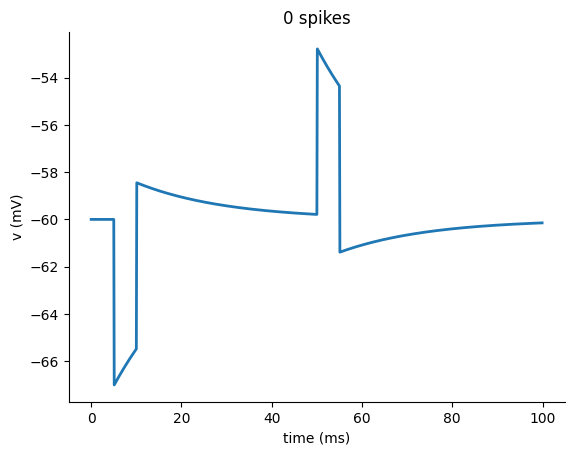

In [4]:
fig, ax = plt.subplots()
ax.plot(state_mon.t/ms, state_mon.V[0]/mV)
ax.set(xlabel="time (ms)", ylabel="v (mV)")
ax.vlines(spike_mon.t/ms, -50, 0)  # draw spikes on top of the membrane potential
ax.set_title(f"{spike_mon.count[0]} spikes");
plt.show()

How can we make things spike without increasing the strength of the synaptic interaction?

Two solutions were proposed.

Solution 1: Lower the threshold

In [5]:
# Modelling synaptic inputs in Brian
start_scope()

# Inputs
exc_inp = SpikeGeneratorGroup(1, [0, 0], [10, 50]*ms)
inh_inp = SpikeGeneratorGroup(1, [0, 0], [ 5, 55]*ms)

C = 200*pF
g_L = 10*nS
E_L = -60*mV

# Neuron
neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L - V))/C : volt (unless refractory)',
                      # Threshold was at -50*mV before
                      threshold='V > -55*mV', reset='V = -80*mV', refractory=5*ms,
                      method='exact')
neurons.V = E_L

# Synapses
exc_syn = Synapses(exc_inp, neurons, on_pre="V_post += 7*mV")  # "on the arrival of a pre-synaptic spike"
exc_syn.connect()
inh_syn = Synapses(inh_inp, neurons, on_pre="V_post -= 7*mV")  # "on the arrival of a pre-synaptic spike"
inh_syn.connect()

# Recordings
state_mon = StateMonitor(neurons, 'V', record=0)
spike_mon = SpikeMonitor(neurons)

run(100*ms)

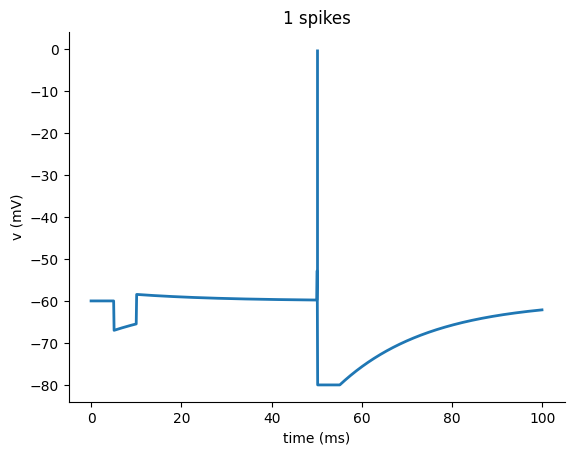

In [6]:
fig, ax = plt.subplots()
ax.plot(state_mon.t/ms, state_mon.V[0]/mV)
ax.set(xlabel="time (ms)", ylabel="v (mV)")
ax.vlines(spike_mon.t/ms, -55, 0)  # draw spikes on top of the membrane potential
ax.set_title(f"{spike_mon.count[0]} spikes");
plt.show()

Solution 2: change the timing of the excitatory spikes, to have them occur in quick succession

In [7]:
# Modelling synaptic inputs in Brian
start_scope()

# Inputs
exc_inp = SpikeGeneratorGroup(1, [0, 0], [49, 50]*ms)  # timing was 10ms, 50ms before
inh_inp = SpikeGeneratorGroup(1, [0, 0], [ 5, 55]*ms)

C = 200*pF
g_L = 10*nS
E_L = -60*mV

# Neuron
neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L - V))/C : volt (unless refractory)',
                      threshold='V > -50*mV', reset='V = -80*mV', refractory=5*ms,
                      method='exact')
neurons.V = E_L

# Synapses
exc_syn = Synapses(exc_inp, neurons, on_pre="V_post += 7*mV")  # "on the arrival of a pre-synaptic spike"
exc_syn.connect()
inh_syn = Synapses(inh_inp, neurons, on_pre="V_post -= 7*mV")  # "on the arrival of a pre-synaptic spike"
inh_syn.connect()

# Recordings
state_mon = StateMonitor(neurons, 'V', record=0)
spike_mon = SpikeMonitor(neurons)

run(100*ms)

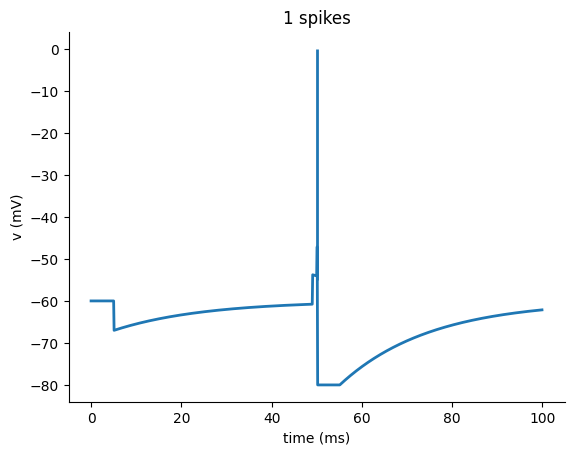

In [8]:
fig, ax = plt.subplots()
ax.plot(state_mon.t/ms, state_mon.V[0]/mV)
ax.set(xlabel="time (ms)", ylabel="v (mV)")
ax.vlines(spike_mon.t/ms, -55, 0)  # draw spikes on top of the membrane potential
ax.set_title(f"{spike_mon.count[0]} spikes");
plt.show()

### Random spike trains
As a first approximation, we can consider incoming spikes to be random. Each neuron receives many (in the cortex on the order of 10000) synaptic inputs, each of them spiking randomly with a certain rate (here, 10Hz).

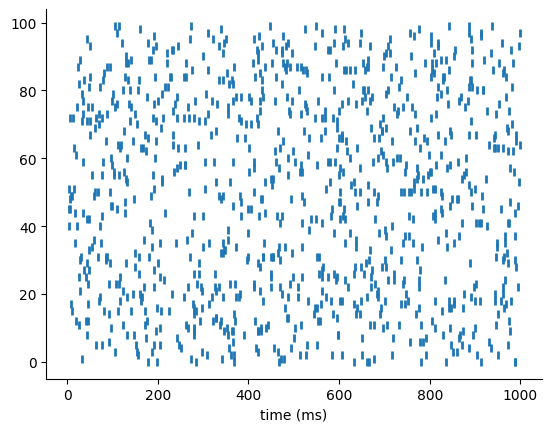

In [9]:
# In Brian, random spikes can be modeled with a PoissonGroup
start_scope()

poisson_group = PoissonGroup(100, rates=10*Hz)
spike_mon = SpikeMonitor(poisson_group)

run(1000*ms)

plt.plot(spike_mon.t/ms, spike_mon.i, '|')
plt.xlabel("time (ms)");

We now inject these random spikes (many of them) into our neuron

In [10]:
start_scope()

# Inputs
N_neurons = 10000
rate = 10*Hz
w_exc = 11*mV/1000

exc_inp = PoissonGroup(N_neurons, rates=rate)

# Neuron
C = 200*pF
g_L = 10*nS
E_L = -60*mV

neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L - V))/C : volt (unless refractory)',
                      threshold='V > -50*mV', reset='V = -80*mV', refractory=5*ms,
                      method='exact')
neurons.V = E_L

# Synapses
exc_syn = Synapses(exc_inp, neurons, on_pre="V_post += w_exc")
exc_syn.connect()

# Recordings
state_mon = StateMonitor(neurons, 'V', record=0)
spike_mon = SpikeMonitor(neurons)

run(1000*ms)

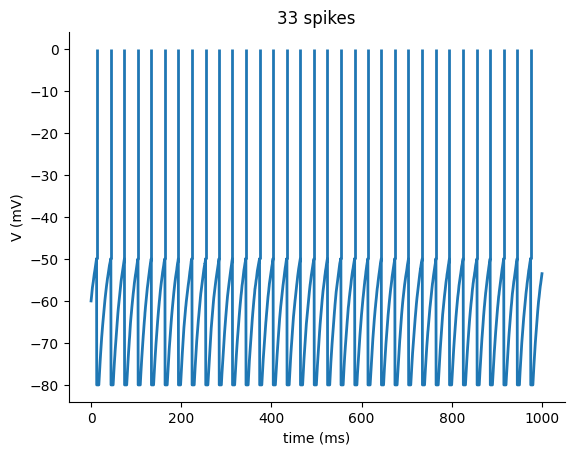

In [11]:
fig, ax = plt.subplots()
ax.plot(state_mon.t/ms, state_mon.V[0]/mV)
ax.set(xlabel="time (ms)", ylabel="V (mV)")
ax.vlines(spike_mon.t/ms, -50, 0)
ax.set_title(f"{spike_mon.count[0]} spikes");

Summing up this large number of spikes leads to an almost constant input current, which leads to a regular spiking cell. This is not what is observed in real cortical neurons.

What is missing from the above model?

Answer: Inhibitory inputs!

The following code has more excitatory than inhibitory neurons, but inhibitory synapses are stronger than excitatory ones (roughly following experimental observations). If you calculate the *average* input, it would be 0! But given that the inputs are random, the actual input fluctuates and sometimes drives the neuron over its threshold.

In [12]:
start_scope()

# Inputs
N_neurons = 10000
rate = 10*Hz
w_exc = .2*mV
w_inh = .8*mV

exc_inp = PoissonGroup(int(0.8*N_neurons), rates=rate)
inh_inp = PoissonGroup(int(0.2*N_neurons), rates=rate)

# Neuron
C = 200*pF
g_L = 10*nS
E_L = -60*mV

neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L - V))/C : volt (unless refractory)',
                      threshold='V > -50*mV', reset='V = -80*mV', refractory=5*ms,
                      method='exact')
neurons.V = E_L

# Synapses
exc_syn = Synapses(exc_inp, neurons, on_pre="V_post += w_exc")
exc_syn.connect()
inh_syn = Synapses(inh_inp, neurons, on_pre="V_post -= w_inh")
inh_syn.connect()

# Recordings
state_mon = StateMonitor(neurons, 'V', record=0)
spike_mon = SpikeMonitor(neurons)

run(1000*ms)

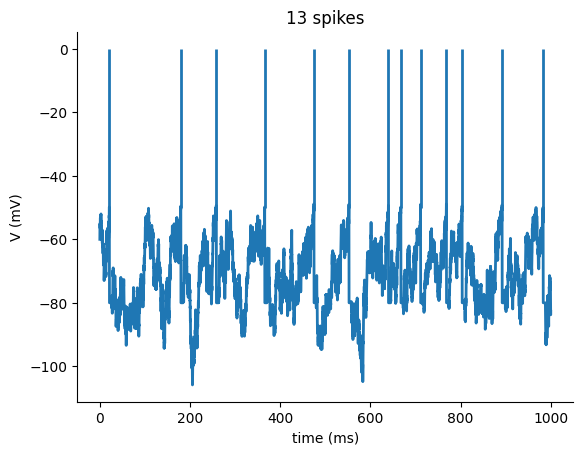

In [13]:
fig, ax = plt.subplots()
ax.plot(state_mon.t/ms, state_mon.V[0]/mV)
ax.set(xlabel="time (ms)", ylabel="V (mV)")
ax.vlines(spike_mon.t/ms, -50, 0)
ax.set_title(f"{spike_mon.count[0]} spikes");

The activity now looks much more realistic, with highly irregular firing.

## Randomly connected network

In [14]:
def run_sim(g, nu_ext_relative, N_E=10000, report='text'):
    start_scope()
    
    # network parameters
    gamma = 0.25
    N_I = int(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = C_ext = int(epsilon * N_E)
    C_I = int(epsilon * N_I)
    # neuron parameters
    tau = 20 * ms; theta = 20 * mV; V_r = 10 * mV; tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV; D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_ext * tau)

    neurons = NeuronGroup(N,"dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta", reset="v = V_r", refractory=tau_rp, method="exact")

    exc_neurons = neurons[:N_E]
    inh_neurons = neurons[N_E:]
    exc_synapses = Synapses(exc_neurons, neurons, on_pre="v_post += J", delay=D)
    exc_synapses.connect(i="k for k in sample(N_E, size=C_E)")  # Each neuron receives C_E connections
    inhib_synapses = Synapses(inh_neurons, neurons, on_pre="v_post += -g*J", delay=D)
    inhib_synapses.connect(i="k for k in sample(N_I, size=C_I)")

    nu_ext = nu_ext_relative * nu_thr
    # More efficient than simulating all incoming external spikes
    external_poisson_input = PoissonInput(target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J)

    rate_monitor = PopulationRateMonitor(neurons)
    exc_monitor = SpikeMonitor(exc_neurons)
    inh_monitor = SpikeMonitor(inh_neurons[:50])  # record 50 inhibitory neurons
    state_monitor = StateMonitor(exc_neurons, 'v', record=0)  # record membrane potential of one neuron
    run(1*second, report=report)
    
    return {'rate_t': rate_monitor.t, 'rate': rate_monitor.rate,
            'exc_spikes_t': exc_monitor.t, 'exc_spikes_i': exc_monitor.i,
            'inh_spikes_t': inh_monitor.t, 'inh_spikes_i': inh_monitor.i,
            'state_t': state_monitor.t, 'state_v': state_monitor.v[0]}

In [15]:
def plot_results(results, title=None):
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2, figure=fig)
    # Create the following subplot mosaic (without using the recent subplot_mosaic function)
    # AC
    # AF
    # DG
    # BH
    axs = {'A': fig.add_subplot(gs[0:2, 0]),
           'B': fig.add_subplot(gs[3, 0]),
           'C': fig.add_subplot(gs[0, 1]),
           'D': fig.add_subplot(gs[2, 0]),
           'F': fig.add_subplot(gs[1, 1]),
           'G': fig.add_subplot(gs[2, 1]),
           'H': fig.add_subplot(gs[3, 1])}
    axs['A'].plot(results['exc_spikes_t'][results['exc_spikes_i']<50]/ms,
                  results['exc_spikes_i'][results['exc_spikes_i']<50], '|')
    axs['A'].plot(results['inh_spikes_t']/ms,
                  -50 + results['inh_spikes_i'], '|', color='darkred')
    axs['A'].set(xlim=(800, 990), xticks=[])
    axs['B'].plot(results['rate_t']/ms, results['rate']/Hz)
    axs['B'].set(xlim=(800, 990), xlabel='t (ms)', ylabel='rate (1/second)')
    # Calculate CV and rate for 1000 neurons:
    CVs = np.empty(1000); rates = np.empty(1000)
    for idx in range(1000):
        if (any(results['exc_spikes_i'] == idx)):
            ISIs = np.diff(results['exc_spikes_t'][results['exc_spikes_i'] == idx]/ms)
            if len(ISIs):
                CVs[idx] = np.std(ISIs)/np.mean(ISIs)
                rates[idx] = 1000*1/np.mean(ISIs)  # rate estimated as inverse of mean ISI
            else:
                CVs[idx] = np.nan
                rates[idx] = np.nan
        else:
            CVs[idx] = np.nan
            rates[idx] = np.nan
    # ISI distribution for neuron 0   
    ISIs = np.diff(results['exc_spikes_t'][results['exc_spikes_i'] == 0]/ms)
    axs['C'].hist(ISIs, bins=np.linspace(0, 50, 25))    
    axs['C'].text(0.95, 0.95,
                  f'ISI distribution for example neuron\nfiring rate: {rates[idx]:.1f}/s\nCV: {CVs[idx]:.2f}''',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['C'].transAxes)
    # Membrane potential for neuron 0
    axs['D'].plot(results['state_t']/ms, results['state_v']/mV)
    axs['D'].vlines(results['exc_spikes_t'][results['exc_spikes_i'] == 0]/ms, 20, 40)
    axs['D'].set(xlabel='t (ms)', ylabel='v (mV)', xlim=(800, 990))
    # Rate distribution
    axs['F'].hist(rates, bins=np.linspace(0, 500, 50))
    axs['F'].text(0.95, 0.95, 'rate distribution',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['F'].transAxes)
    # CV distribution
    axs['G'].hist(CVs, bins=np.linspace(0, 1, 25))
    axs['G'].text(0.95, 0.95, 'CV distribution',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['G'].transAxes)
    # Autocorrelation of rate
    autocorr = np.correlate(results['rate'], results['rate'], mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr /= autocorr[0]
    axs['H'].plot(results['rate_t']/ms, autocorr)
    axs['H'].text(0.95, 0.95, 'rate autocorrelation',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['H'].transAxes)
    axs['H'].set(xlabel='t (ms)', xlim=(0, 100), ylim=(0, 1))
    if title:
        fig.suptitle(title)

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s


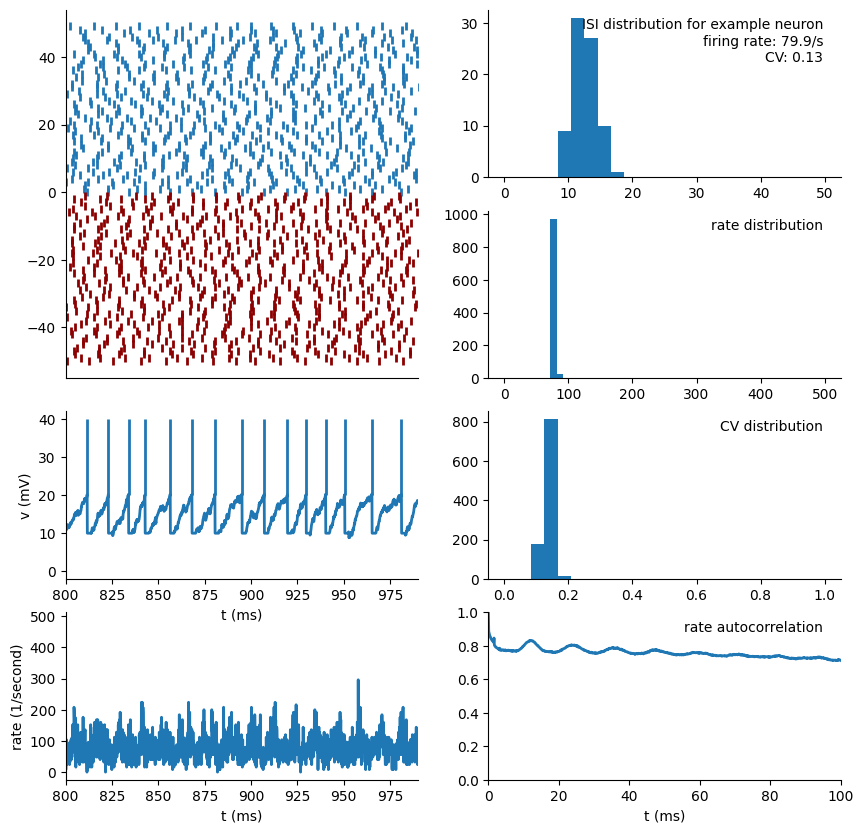

In [16]:
results = run_sim(5.5, 2, N_E=1000)  # small test
plot_results(results)

For the parameters above, the network activity is "regular, asynchronous" – each neuron fires rather regularly (low CV of the ISI distribution), but activity across neurons is not synchronized (firing rate over time is rather flat).

## Appendix: synapse models

Different synaptic models: "delta synapses", current-based and conductance-based (see lecture)

In [17]:
def simulate_synapses(exc_spikes, inh_spikes, synapses='delta'):
    start_scope()
    E_e = 70*mV; E_i = -10*mV
    if synapses == 'delta':
        eqs = "dv/dt = -v/(10*ms) : volt (unless refractory)"
        method = 'exact'
    elif synapses == 'current':
        eqs = '''dv/dt = (-v + I_e + I_i)/(10*ms) : volt (unless refractory)
                 dI_e/dt = -I_e/(5*ms) : volt
                 dI_i/dt = -I_i/(5*ms) : volt'''
        method = 'exact'
    elif synapses == 'conductance':
        eqs = '''dv/dt = (-v + g_e*(E_e - v) + g_i*(E_i - v))/(10*ms) : volt (unless refractory)
                 dg_e/dt = -g_e/(5*ms) : 1
                 dg_i/dt = -g_i/(5*ms) : 1'''
        method = 'euler'
    neurons = NeuronGroup(1, eqs, threshold='v > 10*mV',
                          reset='v = 0*mV', refractory=2*ms, method=method)
    exc_inp = SpikeGeneratorGroup(1, np.zeros(len(exc_spikes)), exc_spikes)
    inh_inp = SpikeGeneratorGroup(1, np.zeros(len(inh_spikes)), inh_spikes)
    if synapses == 'delta':
        exc_syn = Synapses(exc_inp, neurons, on_pre='v_post += 7*mV')
        inh_syn = Synapses(inh_inp, neurons, on_pre='v_post -= 7*mV')
    elif synapses == 'current':
        exc_syn = Synapses(exc_inp, neurons, on_pre='I_e += 25*mV')
        inh_syn = Synapses(inh_inp, neurons, on_pre='I_i -= 27*mV')
    elif synapses == 'conductance':
        exc_syn = Synapses(exc_inp, neurons, on_pre='g_e += 0.4')
        inh_syn = Synapses(inh_inp, neurons, on_pre='g_i += 1.6')
    exc_syn.connect(); inh_syn.connect()
    state_mon = StateMonitor(neurons, 'v', record=0)
    spike_mon = SpikeMonitor(neurons)
    run(200*ms)
    return state_mon.t, state_mon.v[0], spike_mon.t

def plot_synapses_sim(exc_spikes, inh_spikes, mon_t, mon_v, spikes):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 3),
                           gridspec_kw={'height_ratios': (1, 2, 1)})
    axs[0].eventplot(exc_spikes/ms, color='red')
    axs[0].axis('off')
    axs[1].plot(mon_t/ms, mon_v/mV, color='black')
    axs[1].vlines(spikes/ms, 10, 30, color='black')
    axs[1].axhline(color='gray', linestyle=':', zorder=-1)
    axs[1].axhline(10, color='gray', linestyle='--', zorder=-1)
    axs[1].set(xlabel='t (ms)', ylabel='v (mV)', ylim=(-10, 30))
    axs[2].eventplot(inh_spikes/ms, color='blue')
    axs[2].axis('off')

In [18]:
exc_spikes = [10, 50, 55, 105, 110, 150]*ms
inh_spikes = [75, 95, 150, 160]*ms
mon_t, mon_v, spikes = simulate_synapses(exc_spikes, inh_spikes, synapses='delta')

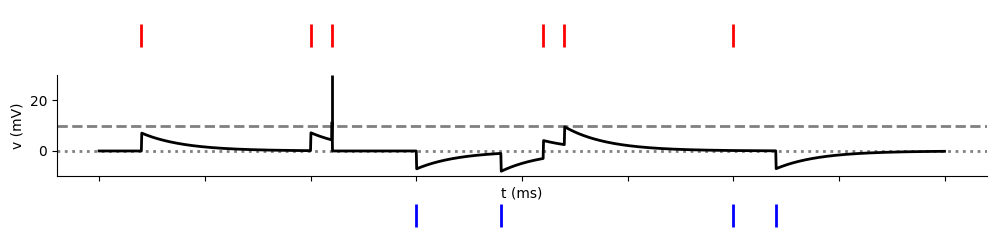

In [19]:
plot_synapses_sim(exc_spikes, inh_spikes, mon_t, mon_v, spikes)